In [2]:
#%pylab
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import cumtrapz
from get_isochrone import *
from multiprocessing import Pool
from scipy.optimize import minimize
from scipy.stats import poisson
from os.path import isfile
from palettable.colorbrewer.qualitative import Dark2_8
from cycler import cycler
from numba import vectorize
from scipy.special import loggamma
from glob import glob

imf_samples = np.load("/home/mgrudic/kroupa_m300_samples.npy")
imf_samples = imf_samples[imf_samples < 150]
plt.rc('axes', prop_cycle=(cycler('linestyle', ['solid', 'dashed', 'dotted']) * cycler('color', Dark2_8.mpl_colors)))
#sqrt_rand = np.sqrt(np.random.rand(10**8))
#random_sorted = np.sort(np.random.rand(10**8))

def inference_experiment(gamma=2.5, background=1e-1, aperture=30, N=10**4,res=0.1,count_photons=False,dist_mpc=10, age=1e8, method="poisson", Lmin=0, filt="ACS_F555W",  exposure_s=1000):
    cluster_radii, background_radii = generate_radii(gamma,background,aperture,N,1.)
    radii = np.concatenate([cluster_radii, background_radii])
    if count_photons:
        res = max(res, 0.5*1.94e-7 * dist_mpc*1e6)
    rbins = np.linspace(0,aperture,int(aperture/res))
    #plt.loglog(rbins[1:],np.histogram(radii,rbins)[0]/(np.pi*np.diff(rbins**2)))
    N = len(radii)
    if count_photons: # mock hubble photon counts
        masses = np.random.choice(imf_samples,N)
        L = get_luminosity(masses,age,filt) #generate_random_luminosities(N, age, filter=filt) # F555W luminosity
        #actual_halflight = 10**np.interp(0.5, L[:len(cluster_radii)].cumsum()/L[:len(cluster_radii)].sum(), np.log10(cluster_radii))
        #r50_desired = (2**(2/(gamma-2))-1)**0.5
        #radii *= r50_desired / actual_halflight #10**np.interp(0.5, np.log10(L.cumsum()/L.sum()), np.log10(radii))
        Q = L / 3.579e-12 # photons per second
        photons_expected = 3.78e-48 * (dist_mpc/10)**-2 * Q * exposure_s # photons expected from each star
        if method=="djorgovski87":
            radii_split = np.array_split(radii,8) # split into 8 sectors
            photons_expected_split = np.array_split(photons_expected,8)
            photons_perbin_expected = [np.histogram(r,rbins,weights=p)[0] for r,p in zip(radii_split,photons_expected_split)]
            N = [np.random.poisson(P,size=P.shape) for P in photons_perbin_expected]
        else:
            photons_perbin_expected = np.histogram(radii,rbins,weights=photons_expected)[0]
            N = np.random.poisson(photons_perbin_expected,size=photons_perbin_expected.shape)
           # print(N)
        mu0_est = photons_expected.sum()/2 / (np.pi*np.median(radii)**2)
    else:
        if method=="djorgovski87":
            radii_split = np.array_split(radii,8)
            N = [np.histogram(r,rbins)[0] for r in radii_split]
        else:
            N = np.histogram(radii,rbins)[0]
        mu0_est = 3/(np.pi*radii[2]**2)

    #print(N)
    if method=="poisson":        
        lossfunc_touse = lossfunc
    else:
        lossfunc_touse = lossfunc_djorgovski87
    p0 = (np.log10(mu0_est),np.log10(background*mu0_est), 0., gamma)
    for i in range(100):
        sol = minimize(lossfunc_touse, np.array(p0) + 0.1*np.random.rand(),args=(rbins,N),method='Nelder-Mead',bounds=[(-10,10),(-10,10),(-10,10),(0,20)],tol=1e-6)
        if sol.success: 
                #if(i>0): print(i)
            break
#    elif method="djorgovski1987":
    if sol.success:    
        return sol.x[2:]
    else:
        return [np.nan, np.nan]

@vectorize(fastmath=True)
def logpoisson(counts, expected_counts):
    if counts == 0:
        logfact = 0
    elif counts < 10:
        fact = counts
        for i in range(2,counts): # factorial
            fact *= i
        logfact = np.log(fact)
    else: # stirling approx
        logfact = np.log(counts)*counts - counts  + np.log(counts*(1 + 4 * counts * (1 + 2*counts)))/6 + np.log(np.pi)*0.5
    return counts * np.log(expected_counts) - expected_counts - logfact

def generate_radii(gamma=2.5, background=1e-1, Rmax=100, N=100,a=1):
    np.random.seed()
    r = np.logspace(-2,np.log10(Rmax),1000)
    norm = (gamma - 2)/(2*np.pi)
    sigma_background = norm * background
    r50 = (2**(2/(gamma-2))-1)**0.5
    r_cluster = np.sort(np.sqrt((1-np.random.rand(N))**(-2/(gamma-2)) - 1))
    r50_desired = (2**(2/(gamma-2))-1)**0.5
    r_cluster *= r50_desired / np.interp(0.5,np.linspace(0,1,N),r_cluster)
    r_cluster = np.sort(r_cluster[r_cluster < Rmax])
    N_background = round(sigma_background * np.pi * Rmax**2 * N)
    #if N_background < 10**6:
    r_background = Rmax * np.sqrt(np.random.rand(N_background))
    #else:
        #r_background = Rmax * sqrt_rand[:N_background]
    #print((r_cluster<1).sum()/np.pi, norm*N)
    return r_cluster, r_background

def lossfunc(x,rbins,bincounts):
    logmu0, logbackground, loga, gam = x
    mu, bg, a = 10**logmu0, 10**logbackground, 10**loga
    cumcounts_avg = 2*a**gam*np.pi*(a**(2-gam) - (a**2 + rbins**2)**(1-gam/2))* mu  / (gam-2) + np.pi*rbins**2*bg
    expected_counts = np.diff(cumcounts_avg)
    prob = logpoisson(bincounts, expected_counts).sum()
    return -prob
    

def lossfunc_djorgovski87(x,rbins,bincounts):
    logmu0, logbackground, loga, gam = x
    mu, bg, a = 10**logmu0, 10**logbackground, 10**loga
    cumcounts_avg = 2*a**gam*np.pi*(a**(2-gam) - (a**2 + rbins**2)**(1-gam/2))* mu  / (gam-2) + np.pi*rbins**2*bg
    expected_counts = np.diff(cumcounts_avg)
    stderr = np.std(bincounts,axis=0)
    N = np.sum(bincounts,axis=0)
    prob = np.sum(-(expected_counts - N)**2/(2*stderr**2))
    return -prob

params = {
    "Fiducial": [2.5,1e-1,10,10**4,0.1],
    #"Djorgovski 1987": [2.5,1e-1,10,10**4,0.1, False,3,1e8,"djorgovski87"],
    r"No Background": [2.5,1e-6,10,10**4,0.1],
    r"Photon counts, 100Myr, 3Mpc, 1000s": [2.5,1e-1,10,10**4,0.1, True,3,1e8],
    r"Photon counts, 100Myr, 30Mpc, 1000s": [2.5,1e-1,30,10**4,0.1, True,30,1e8],
    r"Photon counts, 100Myr, 10Mpc, 1000s": [2.5,1e-1,10,10**4,0.1, True,10,1e8],
    #r"Photon counts, 100Myr, 10Mpc, 1000s (D87)": [2.5,1e-1,10,10**4,0.1, True,10,1e8,"djorgovski87"],
    r"Photon counts, 100Myr, 10Mpc, 1000s, Contrast 100": [2.5,1e-2,10,10**4,0.1, True,10,1e8],
    r"Photon counts, 100Myr, 10Mpc, 1000s, No Background": [2.5,1e-5,10,10**4,0.1, True,10,1e8],
    r"Photon counts, 100Myr, 10Mpc, 1000s, $10^5$ stars": [2.5,1e-1,10,10**5,0.1, True,10,1e8],
    r"Photon counts, 100Myr, 10Mpc, 1000s, $10^6$ stars": [2.5,1e-1,10,10**6,0.1, True,10,1e8],
    r"Photon counts, 300Myr, 10Mpc, 1000s": [2.5,1e-1,10,10**4,0.1, True,10,3e8],
    r"Photon counts, 10Myr, 10Mpc, 1000s": [2.5,1e-1,10,10**4,0.1, True,10,1e7],
    r"Photon counts, 30Myr, 10Mpc, 1000s": [2.5,1e-1,10,10**4,0.1, True,10,3e7],
    r"$10^5$ stars" : [2.5,1e-1,10,10**5,0.1],
    r"$10^3$ stars" : [2.5,1e-1,10,10**3,0.1],
    r"$3\times10^4$ stars" : [2.5,1e-1,10,3*10**4,0.1],
    r"$3\times10^3$ stars" : [2.5,1e-1,10,3*10**3,0.1],
    # r"$30$ stars" : [2.5,1e-1,10,30,0.1],
    r"$10^2$ stars": [2.5,1e-1,10,10**2,0.1],
    r"Aperture $100a$": [2.5,1e-1,100,10**4,0.1],
    r"Aperture $30a$": [2.5,1e-1,30,10**4,0.1],
    r"Aperture $3a$": [2.5,1e-1,3,10**4,0.1],
    r"$\gamma=2.1$": [2.1,1e-1,10,10**4,0.1],
    # r"$\gamma=2.1,\,N=10^4$": [2.1,1e-1,10,10**4,0.1],
    # r"$\gamma=2.1,\,N=10^5$": [2.1,1e-1,10,10**5,0.1],
    # #r"$\gamma=2.1,\,N=10^6$": [2.1,1e-1,10,10**6,0.1],
    #r"$\gamma=2.1$, Aperture=$100a$": [2.1,1e-1,100,10**4,0.1],
    #r"$\gamma=2.1$, Aperture=$300a$": [2.1,1e-1,300,10**4,0.1],
    #r"$\gamma=2.1$, Contrast=$100$": [2.1,1e-2,10,10**4,0.1],
    r"$\gamma=2.3$": [2.3,1e-1,10,10**4,0.1],
    r"$\gamma=3$": [3.,1e-1,10,10**4,0.1],
    r"$\gamma=4$": [4.,1e-1,10,10**4,0.1],
    #r"Resolution $0.01a$": [2.5,1e-1,10,10**4,1.],
    #r"Resolution $1a$":[2.5,0.1,10,10**4,1.],
    r"Contrast 1": [2.5,1.,10,10**4,0.1],
    r"Contrast 100": [2.5,0.01,10,10**4,0.1],
    #r"Resolution $10a$": [2.5,1e-1,10,10**4,10],
}

from multiprocessing import Pool
#Nsamples = 10**3

def do_params_survey(params, Nsamples=10**3):
    for label, p in params.items():
        print(label)
        path = "r50_samples_gamma2.5/r50_samples_"+label.replace(" ", "")+".npy"
        print(path)
        if isfile(path):
            if len(np.load(path)) == Nsamples: continue    
        #with Pool(1) as pool:
            #result = np.array(pool.starmap(inference_experiment, Nsamples*[p]))
        result = np.array([inference_experiment(*p) for i in range(Nsamples)])
        #def func(p):
            #return
        #result = Pool(min(32,len(params))).starmap(inference_experiment, params.values())
        np.save(path, result)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Fiducial r50_samples/r50_samples_Fiducial.npy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No Background r50_samples/r50_samples_NoBackground.npy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Photon counts, 100Myr, 3Mpc, 1000s r50_samples/r50_samples_Photoncounts,100Myr,3Mpc,1000s.npy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Photon counts, 100Myr, 30Mpc, 1000s r50_samples/r50_samples_Photoncounts,100Myr,30Mpc,1000s.npy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Photon counts, 100Myr, 10Mpc, 1000s r50_samples/r50_samples_Photoncounts,100Myr,10Mpc,1000s.npy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Photon counts, 100Myr, 10Mpc, 1000s, Contrast 100 r50_samples/r50_samples_Photoncounts,100Myr,10Mpc,1000s,Contrast100.npy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Photon counts, 100Myr, 10Mpc, 1000s, No Background r50_samples/r50_samples_Photoncounts,100Myr,10Mpc,1000s,NoBackground.npy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Photon counts, 100Myr, 10Mpc, 1000s, $10^5$ stars r50_samples/r50_samples_Photoncounts,100Myr,10Mpc,1000s,$10^5$stars.npy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Photon counts, 100Myr, 10Mpc, 1000s, $10^6$ stars r50_samples/r50_samples_Photoncounts,100Myr,10Mpc,1000s,$10^6$stars.npy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Photon counts, 300Myr, 10Mpc, 1000s r50_samples/r50_samples_Photoncounts,300Myr,10Mpc,1000s.npy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Photon counts, 10Myr, 10Mpc, 1000s r50_samples/r50_samples_Photoncounts,10Myr,10Mpc,1000s.npy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Photon counts, 30Myr, 10Mpc, 1000s r50_samples/r50_samples_Photoncounts,30Myr,10Mpc,1000s.npy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


$10^5$ stars r50_samples/r50_samples_$10^5$stars.npy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


$10^3$ stars r50_samples/r50_samples_$10^3$stars.npy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


$3\times10^4$ stars r50_samples/r50_samples_$3\times10^4$stars.npy


KeyboardInterrupt: 

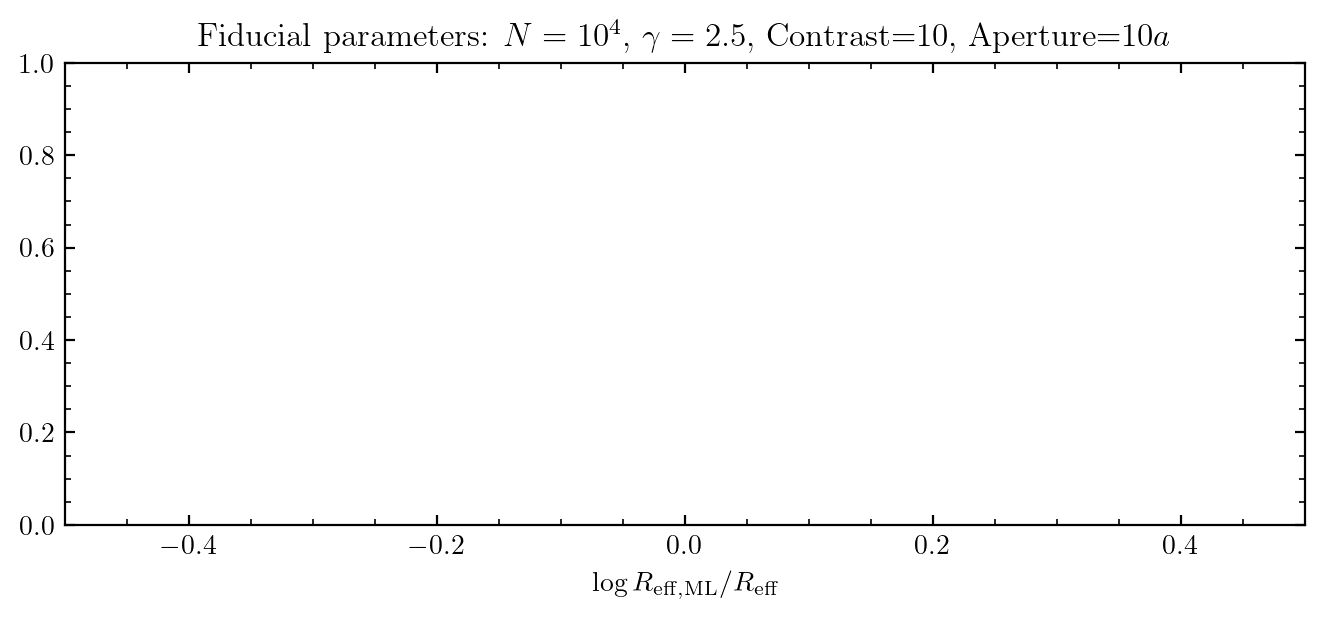

In [24]:
plt.figure(figsize=(8,3))
# params = {
#     "Star counts, $N=10^3$": [2.5,1e-4,10,10**3,0.1],
#     "Star counts, $N=10^4$": [2.5,1e-4,10,10**4,0.1],
#     "Star counts, $N=10^5$": [2.5,1e-4,10,10**5,0.1],
#     "Star counts, $N=10^6$": [2.5,1e-4,10,10**6,0.1],
#     r"F555W counts, $N=10^3$, 100Myr, 10Mpc, 1000s": [2.5,1e-4,10,10**3,0.1, True,10,1e8],
#     r"F555W counts, $N=10^4$, 100Myr, 10Mpc, 1000s": [2.5,1e-4,10,10**4,0.1, True,10,1e8],
#     r"F555W counts, $N=10^5$, 100Myr, 10Mpc, 1000s": [2.5,1e-4,10,10**5,0.1, True,10,1e8],
#     r"F555W counts, $N=10^6$, 100Myr, 10Mpc, 1000s": [2.5,1e-4,10,10**6,0.1, True,10,1e8],
# }

for label, p in params.items():
    #if not ("Fiducial" in label or "Photon" in label or "No Background" in label or "Dj" in label or "stars" in label): continue
    #if not (("Aperture" in label) or ("Fiducial" in label)): continue
    #if not (("stars" in label) or ("Fiducial" in label)): continue
    path = f"r50_samples/r50_samples_"+label.replace(" ", "")+".npy"
    print(label,path)
    r50_0 = (2**(2/(p[0]-2))-1)**0.5
    
    if isfile(path):
        result = np.load(path)
        r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
        r50[np.isnan(r50)] = np.inf
        if label == "Fiducial": label = "Complete star counts"
        if label == "No Background": label = "Complete star counts (No Background)"
        plt.ecdf(np.log10(r50/r50_0).clip(-2,10),label=label);# plt.yscale('log')

    plt.xlim(-0.5,.5)
    plt.legend(labelspacing=0,ncol=1,fontsize=8)
    plt.xlabel(r"$\log R_{\rm eff,ML}/R_{\rm eff}$")
    plt.title(r"Fiducial parameters: $N=10^4$, $\gamma=2.5$, Contrast=10, Aperture=$10a$")
    #plt.title(r"Counting Stars ($N=10^4$, Aperture=10a, Contrast=10, $\gamma=2.5$)")
    plt.savefig("counting_stars.pdf",bbox_inches='tight')
    #break

In [3]:
gamma_param = 2.5

agegrid = [1e6,1e7,1e8,1e9]
Ngrid = [10**3,10**4,10**5,10**6]
gammagrid = [2.5,3,4]
apgrid = [3,10,30,100]

params = {
    "Star counts, $N=10^3$": [gamma_param,1e-6, 100,10**3,0.1],
    "Star counts, $N=10^4$": [gamma_param,1e-6, 100,10**4,0.1],
    "Star counts, $N=10^4$, Aperture 10": [gamma_param,1e-6, 10,10**4,0.1],
    "Star counts, $N=10^4$, Aperture 30": [gamma_param,1e-6, 30,10**4,0.1],
    "Star counts, $N=10^4$, Aperture 3": [gamma_param,1e-6, 3,10**4,0.1],
    "Star counts, $N=10^4$, Contrast $10^4$": [gamma_param,1e-4,100,10**4,0.1],
    "Star counts, $N=10^4$, Contrast 1000": [gamma_param,1e-3,100,10**4,0.1],
    "Star counts, $N=10^4$, Contrast 100": [gamma_param,1e-2,100,10**4,0.1],
    "Star counts, $N=10^4$, Contrast 10": [gamma_param,1e-1,100,10**4,0.1],
    "Star counts, $N=10^4$, Contrast 1": [gamma_param,1.,100,10**4,0.1],
    "Star counts, $N=10^5$, Contrast 1000": [gamma_param,1e-3,100,10**5,0.1],
    "Star counts, $N=10^5$, Contrast 100": [gamma_param,0.01,100,10**5,0.1],
    "Star counts, $N=10^5$, Contrast 10": [gamma_param,0.1,100,10**5,0.1],
    "Star counts, $N=10^5$": [gamma_param,1e-6, 100,10**5,0.1],
    "Star counts, $N=10^5$, Aperture  30": [gamma_param,1e-6, 30,10**5,0.1],
    "Star counts, $N=10^5$, Aperture  10": [gamma_param,1e-6, 10,10**5,0.1],
    "Star counts, $N=10^5$, Aperture  3": [gamma_param,1e-6, 3,10**5,0.1],
    "Star counts, $N=10^6$": [gamma_param,1e-6, 100,10**6,0.1],
    "Star counts, $N=10^6$, Contrast 1000": [gamma_param,1e-3, 100,10**6,0.1],
    "Star counts, $N=10^6$, Aperture 30": [gamma_param,1e-6, 30,10**6,0.1],
    "Star counts, $N=10^6$, Aperture 10": [gamma_param,1e-6, 10,10**6,0.1],
    "Star counts, $N=10^6$, Aperture 10, Contrast 1000": [gamma_param,1e-3, 10,10**6,0.1],
    "Star counts, $N=10^6$, Aperture 3, Contrast 1000": [gamma_param,1e-3, 10,10**6,0.1],
    "Star counts, $N=10^6$, Aperture 3, Contrast 100": [gamma_param,1e-2, 10,10**6,0.1],
    r"Light, $N=10^3$, 100Myr, 10Mpc": [gamma_param,1e-6, 100,10**3,0.1, True,10,1e8],
    r"Light, $N=10^4$, 100Myr, 10Mpc": [gamma_param,1e-6, 100,10**4,0.1, True,10,1e8],
    r"Light, $N=10^4$, 10Myr, 10Mpc": [gamma_param,1e-6, 100,10**4,0.1, True,1,1e7],
    r"Light, $N=10^4$, 1Gyr, 10Mpc": [gamma_param,1e-6, 100,10**4,0.1, True,1,1e9],
    r"Light, $N=10^5$, 100Myr, 10Mpc": [gamma_param,1e-6, 100,10**5,0.1, True,10,1e8],
    r"Light, $N=10^6$, 100Myr, 10Mpc": [gamma_param,1e-6, 100,10**6,0.1, True,10,1e8],
    r"Light, $N=10^4$, 100Myr, 10Mpc, Aperture 30": [gamma_param,1e-6, 30,10**4,0.1, True,10,1e8],
    r"Light, $N=10^5$, 100Myr, 10Mpc, Aperture 30": [gamma_param,1e-6, 30,10**5,0.1, True,10,1e8],
    r"Light, $N=10^6$, 100Myr, 10Mpc, Aperture 30": [gamma_param,1e-6, 30,10**6,0.1, True,10,1e8],
    r"Light, $N=10^6$, 100Myr, 10Mpc, Aperture 10": [gamma_param,1e-6, 10,10**6,0.1, True,10,1e8],
    r"Light, $N=10^6$, 100Myr, 10Mpc, Aperture 10, Contrast 1000": [gamma_param,1e-3, 10,10**6,0.1, True,10,1e8],
    r"Light, $N=10^6$, 100Myr, 10Mpc, Aperture 3": [gamma_param,1e-6, 3,10**6,0.1, True,10,1e8],
    r"Light, $N=10^6$, 100Myr, 10Mpc, Aperture 3, Contrast 1000": [gamma_param,1e-3, 3,10**6,0.1, True,10,1e8],
    r"Light, $N=10^6$, 100Myr, 10Mpc, Aperture 3, Contrast 100": [gamma_param,1e-2, 3,10**6,0.1, True,10,1e8]
}

#do_params_survey(params)
# do_params_survey(params,Nsamples=10**4)

# plt.figure(figsize=(8,3))
# stds = []
# Neffs = []
# N = []
# backgrounds = []
# bias = []
# stars = []
# for label, p in params.items():
#     #if not ("Fiducial" in label or "Photon" in label or "No Background" in label or "Dj" in label or "stars" in label): continue
#     #if not (("Aperture" in label) or ("Fiducial" in label)): continue
#     #if not (("stars" in label) or ("Fiducial" in label)): continue
#     path = f"r50_samples/r50_samples_"+label.replace(" ", "")+".npy"
#     #print(label,path)
#     r50_0 = (2**(2/(p[0]-2))-1)**0.5
    
#     if isfile(path):
#         result = np.load(path)
#         r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
#         r50[np.isnan(r50)] = np.inf
#         Neff = p[3]
#         background = p[1]
#         if "Light" in label:
#             Neff *= 0.015
#         Neff /= (1 + (background / 3e-3))
#         std = np.diff(np.percentile(np.log10(r50/r50_0),[16,84]))[0]
#         Neffs.append(Neff); backgrounds.append(background)
#         stds.append(std)
#         bias.append(np.median(np.log10(r50/r50_0)[np.isfinite(r50)]))
#         print(label,std, bias[-1])
#         if np.isnan(std) or std > 1: continue        
#         plt.loglog(Neff,stds[-1],'.',label=label,marker=("d" if "Light" in label else 's'))
# plt.xlabel(r"$N_{\rm eff}$")
# plt.ylabel(r"$\sigma_{\rm \log R_{\rm eff}}$ (dex)")
# plt.legend(labelspacing=0,ncol=2,fontsize=8)
# plt.savefig("Neff_vs_error.pdf",bbox_inches='tight')

# plt.clf()
# plt.figure(figsize=(4,4))
# stds = []
# for label, p in params.items():    
#     path = f"r50_samples_gamma2.5/r50_samples_"+label.replace(" ", "")+".npy"
#     r50_0 = (2**(2/(p[0]-2))-1)**0.5
    
#     if isfile(path):
#         result = np.load(path)
#         r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
#         r50[np.isnan(r50)] = np.inf
#         Neff = p[3]
#         background = p[1]
#         #if "Light" in label:
#             #Neff *= 0.015
#         #Neff /= (1 + (background / 3e-3))
#         std = np.diff(np.percentile(np.log10(r50/r50_0),[16,84]))[0]
#         Neffs.append(Neff); backgrounds.append(background)
#         stds.append(std)
#         bias.append(np.median(np.log10(r50/r50_0)[np.isfinite(r50)]))
#         print(label,std, bias[-1])
#         if not np.isfinite(std): continue
#         plt.loglog(Neff,stds[-1],'.',label=label,marker=("d" if "Light" in label else 's'))
# plt.xlabel(r"$N$")
# plt.ylim(1e-3,1)
# plt.ylabel(r"$\sigma_{\rm \log R_{\rm eff,measured}/R_{\rm eff}}$ (dex)")        
# plt.legend(labelspacing=0,ncol=2,fontsize=8)
# plt.savefig("N_vs_error.pdf",bbox_inches='tight')

/tmp/ipykernel_990627/2637950553.py:20: RuntimeWarning: invalid value encountered in sqrt
  r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
/tmp/ipykernel_990627/2637950553.py:20: RuntimeWarning: overflow encountered in power
  r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)


[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.18734298568167432
        x: [ 6.084e-01  8.422e-01 -4.659e-01  5.661e-01 -1.936e+00
             1.083e+00 -1.095e+00]
      nit: 30
      jac: [-6.484e-06 -5.588e-07 -2.237e-06 -1.898e-06 -1.974e-07
            -4.387e-06 -3.021e-06]
 hess_inv: [[ 3.507e-01 -6.277e-01 ... -2.853e-02 -2.916e-01]
            [-6.277e-01  4.920e+00 ...  1.869e-01  1.866e-01]
            ...
            [-2.853e-02  1.869e-01 ...  1.982e-01 -4.474e-02]
            [-2.916e-01  1.866e-01 ... -4.474e-02  4.273e-01]]
     nfev: 272
     njev: 34 [4.05866925e+00 6.95377211e+00 3.42032777e-01 3.68185289e+00
 1.15834786e-02 1.2

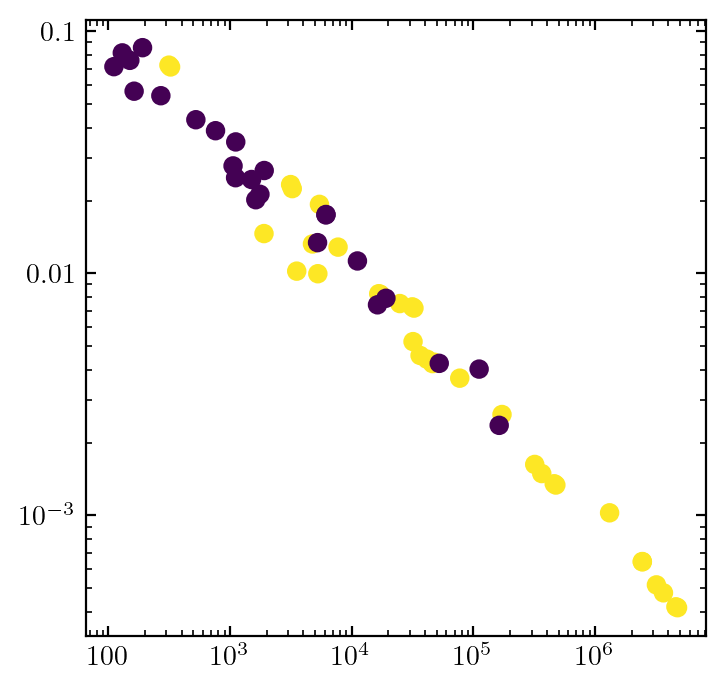

In [10]:
from scipy.optimize import curve_fit

stds = []
Neffs = []
N = []
backgrounds = []
gammas = []
bias = []
stars = []
apertures = []
ages = []
for P in "r50_samples", "r50_samples_gamma2.5":
    for label, p in params.items():
        #path = f"r50_samples_gamma2.5/r50_samples_"+label.replace(" ", "")+".npy"
        path = P+"/r50_samples_"+label.replace(" ", "")+".npy"
    #for path in glob("r50_samples*/*.npy"):
        if isfile(path):
            #print(p)
            result = np.load(path)
            r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
            r50_0 = (2**(2/(p[0]-2))-1)**0.5
            r50[np.isnan(r50)] = np.inf
            Neff = p[3]
            if "gamma2.5" in P: gammas.append(p[0])
            else: gammas.append(4) # GROSS
            background = p[1]
            if "Light" in label:
                stars.append(True)
            else:
                stars.append(False)
            apertures.append(p[2])
            ages.append((p[-1] if len(p)>6 else 1e8))
            N.append(p[3])
            std = np.diff(np.percentile(np.log10(r50/r50_0),[16,84]))[0]
            backgrounds.append(background)
            stds.append(std)
            bias.append(np.median(np.log10(r50/r50_0)[np.isfinite(r50)]))
print(gammas)
gammas, ages, stds, N, backgrounds, bias, stars, apertures = np.array(gammas), np.array(ages), np.array(stds), np.array(N), np.array(backgrounds), np.array(bias), np.array(stars), np.array(apertures)
cut =  np.isfinite(stds) * (stds < 0.1) * (ages == 1e8) #* (backgrounds==1e-6)



def model(x):
    Reff_model = (2**(2/(gammas[cut]-2)) - 1)**0.5
    Reff_SNR = 0.5 / (backgrounds[cut] * np.pi * Reff_model**2) # ratio of true counts within Reff to total counts
    ap_over_Reff = apertures[cut] / Reff_model
    m = 10**x[0] * N[cut]**-0.5 * (1 + (Reff_SNR/10**x[1])**x[2]) * (1 + (ap_over_Reff/10**x[3])**x[4]) * np.exp(x[6]*(gammas[cut]-2))#**x[6]# + x[7])
    #m = 10**x[0] * N[cut]**-0.5 * (Reff_SNR/10**x[1])**x[2] * (ap_over_Reff/10**x[3])**x[4]
    #m = 10**x[0] * N[cut]**-0.5 * (1 + (backgrounds[cut]/10**x[1])**x[2]) * (1 + (apertures[cut]/10**x[3])**x[4])
    #m = 10**x[0] * N[cut]**-0.5 * (1 + (backgrounds[cut]/10**x[1])**x[2]) * (1 + (apertures[cut]/10**x[3])**x[4]) * (ages[cut]/1e8)**x[6]
    #m = 10**x[0] * N[cut]**-0.5 * (1 + (backgrounds[cut]/10**x[1] * N[cut]**x[6])**x[2]) * (1 + (apertures[cut]/10**x[3] * N[cut]**x[7])**x[4])
    #m = 10**x[0] * N[cut]**-0.5 * (1 + (backgrounds[cut]/10**x[1] * N[cut]**x[6])**x[2]) * (1 + (apertures[cut]/10**x[3])**x[4])
    if np.any(stars[cut]): m[stars[cut]] *= 10**x[5]
    return m

def lossfunc(x, *args):
    m = model(x)
    return np.mean(np.log(m/stds[cut])**2)**0.5

#sol = minimize(lossfunc, (0.,-3,0.5,-3,0.5,1,))
sol = minimize(lossfunc, (0.,0,0.5,0,0.5,1,-1))
#modelval = (10**sol[0] * N[cut]**-0.5 * (1 + backgrounds[cut]**sol[2]*10**sol[1]))
print(sol,10**sol.x)
plt.scatter(model(sol.x)**-2,stds[cut],c=gammas[cut]); plt.xscale('log'); plt.yscale('log')



Fiducial
Fiducial [4.87065774e-01 5.98880905e-01 1.62972434e+00 2.58198890e+05
 8.78145630e+10]
$\gamma=2.1$
$\gamma=2.1$ [3.31569543e-13 2.30745631e-12 2.10472286e-11 8.07597747e-11
 9.76562966e+02]
$\gamma=2.3$
$\gamma=2.3$ [2.69671112e-01 5.16656708e-01 9.78730528e-01 9.97044815e+04
 9.97044815e+04]
$\gamma=3$
$\gamma=3$ [0.86842652 0.94412948 1.08286618 1.39201443 2.2258116 ]
$\gamma=4$
$\gamma=4$ [0.83439039 0.84749798 0.86273535 0.8786917  0.89306089]


/tmp/ipykernel_767921/3449539088.py:17: RuntimeWarning: overflow encountered in power
  r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
/tmp/ipykernel_767921/3449539088.py:17: RuntimeWarning: invalid value encountered in sqrt
  r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)


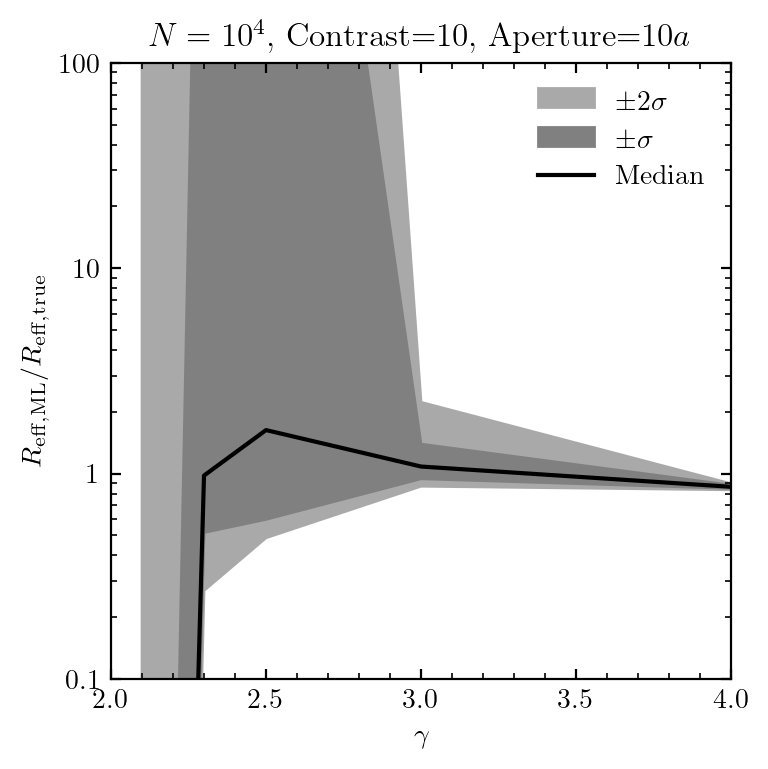

In [24]:
gammas = []np.linalg.eig(sol.hess_inv)" in label) or ("Fiducial" in label)): continue
    if "N=" in label or "Aperture" in label or "Contrast" in label: continue
    path = f"r50_samples_"+label.replace(" ", "")+".npy"
    print(label)
    
    r50_0 = (2**(2/(p[0]-2))-1)**0.5
    
    if isfile(path):
        result = np.load(path)
        r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
        r50[np.isnan(r50)] = 1e6
        rs.append(r50/r50_0)
        print(label,np.percentile(r50/r50_0,[2.5,16,50,84,97.5]))
        if "Fiducial" in label: gammas.append(2.5)
        else: gammas.append(float(label.split("gamma=")[1].split("$")[0]))


fig, ax = plt.subplots()
gammas = np.array(gammas)
rmed = np.array([np.median(R) for R in rs])
quantiles = np.array([np.percentile(R,[2.5,16,50,84,97.5]) for R in rs])
ax.fill_between(gammas[gammas.argsort()], quantiles[gammas.argsort(),0],quantiles[gammas.argsort(),4],color='darkgrey',label=r"$\pm 2\sigma$")
ax.fill_between(gammas[gammas.argsort()], quantiles[gammas.argsort(),1],quantiles[gammas.argsort(),3],color='grey',label=r"$\pm \sigma$")
ax.plot(gammas[gammas.argsort()], rmed[gammas.argsort()],color='black',label="Median")
ax.set(yscale='log',ylim=[0.1,100],xlabel=r"$\gamma$",ylabel=r"$R_{\rm eff,ML}/R_{\rm eff,true}$",xlim=[2,4])
ax.legend()
ax.set_title(r"$N=10^4$, Contrast=10, Aperture=$10a$")
plt.savefig("gamma_vs_refftrue.pdf",bbox_inches='tight')
        #plt.ecdf(np.log10(r50/r50_0).clip(-2,10),label=label);# plt.yscale('log')
        ##plt.ecdf(result[:,1][(~np.isnan(result[:,1]))]-p[0],label=label)

    #plt.xlim(-1,1)
    #plt.legend()
    

(0.0, 6.0)

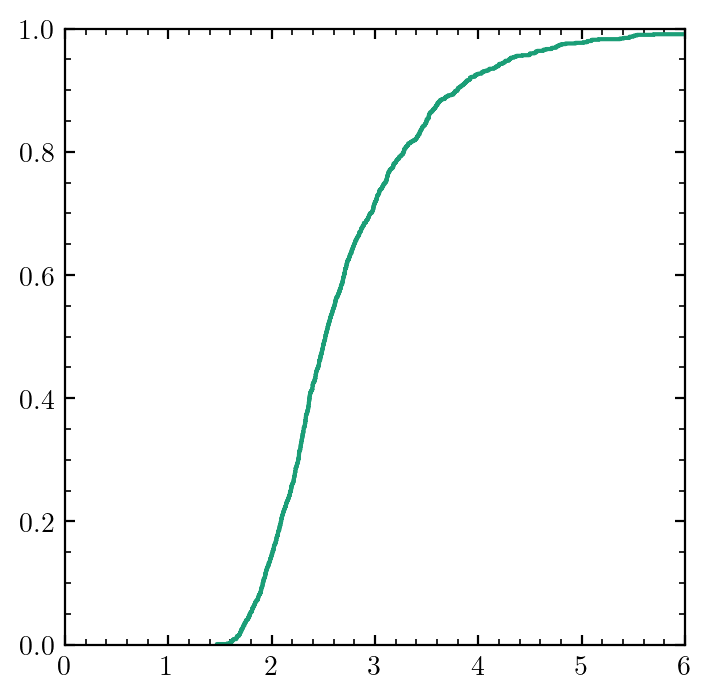

In [49]:
data = np.load("r50_samples_Photoncounts,100Myr,10Mpc,1000s.npy")
rc = data[:,0] * (2**(1/(data[:,1]/2))-1)**0.5
plt.ecdf(data[:,1][~np.isnan(data[:,1])]); plt.xlim(0,6)
#data = data[~np.any(np.isnan(data),axis=1)]
#plt.ecdf(data[:,0] * (2**(1/(data[:,1]/2)-1)**0.5))
#plt.ecdf(np.load("r50_samples_Photoncounts,100Myr,10Mpc,1000s.npy")[:,0]);# plt.xlim(2,5)

## gamma vs reff

Fiducial
Fiducial [  0.55042858   0.67132133   0.98251323   2.39798516 100.42709928]
$10^4$ stars
$10^4$ stars [0.76164839 0.85555596 0.9986683  1.21875572 1.5716284 ]
$3\times10^3$ stars
$3\times10^3$ stars [0.65039842 0.77073541 0.99363591 1.50426933 3.08606514]
$3\times10^2$ stars
$3\times10^2$ stars [4.48744068e-01 5.53043525e-01 9.52014749e-01 2.47505113e+01
 5.24789947e+05]
$30$ stars
$30$ stars [7.48970483e-02 3.02953335e-01 5.18600193e-01 8.56140553e+04
 2.58198890e+05]
$10^2$ stars
$10^2$ stars [3.77746667e-01 4.64208529e-01 8.52913597e-01 2.58198890e+05
 2.73987895e+06]


/tmp/ipykernel_16908/1290587143.py:25: RuntimeWarning: overflow encountered in power
  r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
/tmp/ipykernel_16908/1290587143.py:25: RuntimeWarning: invalid value encountered in sqrt
  r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)


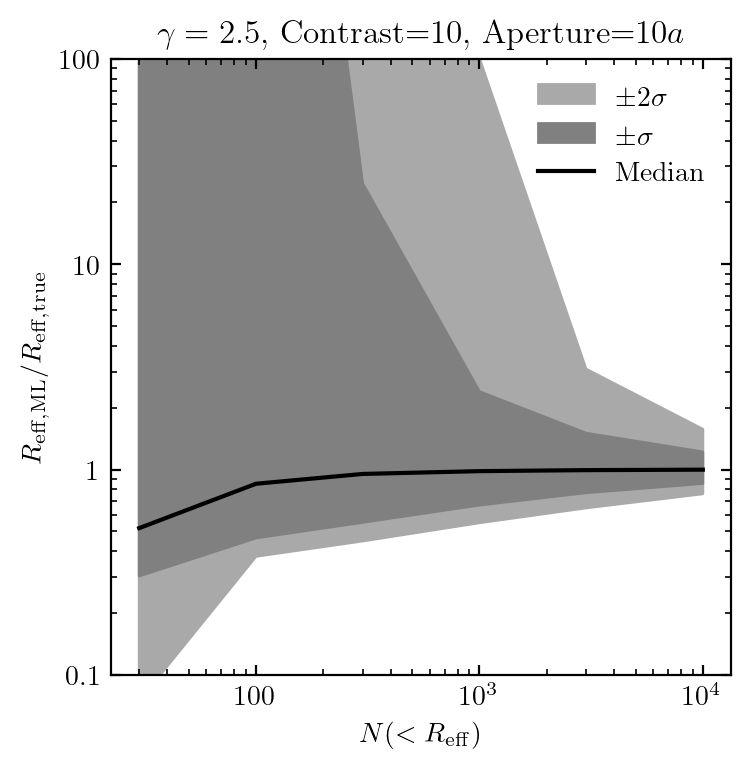

In [47]:
Ns = []
rs = []
Ndict = {
    r"$10^4$ stars" : 10**4,
    r"$3\times10^3$ stars" : 3*10**3,
    r"$3\times10^2$ stars" : 300,
    r"$30$ stars" : 30,
    r"$10^2$ stars": 100,
    "Fiducial": 10**3
}

for label, p in params.items():
    #if not (("Aperture" in label) or ("Fiducial" in label)): continue
    #if not (("N=" in label) or ("Fiducial" in label)): continue
    #if "N=" in label or "Aperture" in label or "Contrast" in label: continue
    #if "gamma=" in label: continue
    if not label in Ndict.keys(): continue
    path = f"r50_samples_"+label.replace(" ", "")+".npy"
    print(label)
    
    r50_0 = (2**(2/(p[0]-2))-1)**0.5
    
    if isfile(path):
        result = np.load(path)
        r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
        r50[np.isnan(r50)] = 1e6
        rs.append(r50/r50_0)
        print(label,np.percentile(r50/r50_0,[2.5,16,50,84,97.5]))
        if "Fiducial" in label: Ns.append(10**3)
        else: Ns.append(Ndict[label])


fig, ax = plt.subplots()
Ns = np.array(Ns)
rmed = np.array([np.median(R) for R in rs])
quantiles = np.array([np.percentile(R,[2.5,16,50,84,97.5]) for R in rs])
ax.fill_between(Ns[Ns.argsort()], quantiles[Ns.argsort(),0],quantiles[Ns.argsort(),4],color='darkgrey',label=r"$\pm 2\sigma$")
ax.fill_between(Ns[Ns.argsort()], quantiles[Ns.argsort(),1],quantiles[Ns.argsort(),3],color='grey',label=r"$\pm \sigma$")
ax.plot(Ns[Ns.argsort()], rmed[Ns.argsort()],color='black',label="Median")
ax.set(yscale='log',xscale='log',ylim=[0.1,100],xlabel=r"$N(<R_{\rm eff})$",ylabel=r"$R_{\rm eff,ML}/R_{\rm eff,true}$")
ax.legend()
ax.set_title(r"$\gamma=2.5$, Contrast=10, Aperture=$10a$")
plt.savefig("N_vs_refftrue.pdf",bbox_inches='tight')        #plt.ecdf(np.log10(r50/r50_0).clip(-2,10),label=label);# plt.yscale('log')
        ##plt.ecdf(result[:,1][(~np.isnan(result[:,1]))]-p[0],label=label)

    #plt.xlim(-1,1)
    #plt.legend()
    

In [30]:
aps = []
rs = []
Ndict = {
    r"Aperture $100a$": 100,
    r"Aperture $30a$": 30,
    r"Aperture $3a$": [2.5,1e-1,3,10**3,0.1],
    "Fiducial": 10**3
}

for label, p in params.items():
    #if not (("Aperture" in label) or ("Fiducial" in label)): continue
    #if not (("N=" in label) or ("Fiducial" in label)): continue
    #if "N=" in label or "Aperture" in label or "Contrast" in label: continue
    #if "gamma=" in label: continue
    if not label in Ndict.keys(): continue
    path = f"r50_samples_"+label.replace(" ", "")+".npy"
    print(label)
    
    r50_0 = (2**(2/(p[0]-2))-1)**0.5
    
    if isfile(path):
        result = np.load(path)
        r50 = 10**result[:,0] * np.sqrt(2**(2/(np.array(result[:,1])-2))-1)
        r50[np.isnan(r50)] = 1e6
        rs.append(r50/r50_0)
        print(label,np.percentile(r50/r50_0,[2.5,16,50,84,97.5]))
        if "Fiducial" in label: Ns.append(10**3)
        else: Ns.append(Ndict[label])


fig, ax = plt.subplots()
Ns = np.array(Ns)
rmed = np.array([np.median(R) for R in rs])
quantiles = np.array([np.percentile(R,[2.5,16,50,84,97.5]) for R in rs])
ax.fill_between(Ns[Ns.argsort()], quantiles[Ns.argsort(),0],quantiles[Ns.argsort(),4],color='darkgrey',label=r"$\pm 2\sigma$")
ax.fill_between(Ns[Ns.argsort()], quantiles[Ns.argsort(),1],quantiles[Ns.argsort(),3],color='grey',label=r"$\pm \sigma$")
ax.plot(Ns[Ns.argsort()], rmed[Ns.argsort()],color='black',label="Median")
ax.set(yscale='log',xscale='log',ylim=[0.1,100],xlabel=r"$N(<R_{\rm eff})$",ylabel=r"$R_{\rm eff,ML}/R_{\rm eff,true}$")
ax.legend()
ax.set_title(r"$\gamma=2.5$, Contrast=10, Aperture=$10a$")
plt.savefig("N_vs_refftrue.pdf",bbox_inches='tight')  

NameError: name 'default_params' is not defined

In [4]:
#np.max(10**result[:,0]*np.sqrt(2**(2/(np.array(result[:,1])-2))-1)/(2**(2/(2.5-2))-1)**0.5)
plt.show()